### $\sigma_z$, $z_{50}$, metalicidad y SFR vs age para distintos radios

Estrellas a z=0




In [42]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import z50 as z50_prof
import velocity_dispersion as vd
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for i in range(1):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Rvir = snap['/R200'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    met  = snap['/Str/Total_Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    Ztot = met[amask]/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]
    
    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    Rn_str = np.sqrt(xn_str**2 + yn_str**2)

    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    radius = (5,7,9,11)# (r50/4, r50/2, r50, r50+r50/2, r50*2)
    
    age_bin = np.linspace(0,14,50)
    
    for k in range(len(radius)):
        
        gal, = np.where((Rn_str < radius[k]+1) & (Rn_str > radius[k]-1) & (zn_str < 5) & (zn_str > -5))
        
        w0, = np.where(Ztot[gal]>0)
    
        edad  = age[gal][w0]
        x_str = xn_str[gal][w0]
        y_str = yn_str[gal][w0]
        z_str = zn_str[gal][w0]
        Z_tot = Ztot[gal][w0]
        m_str = mstr[gal][w0]

        

        sigma_z = np.zeros(len(age_bin)-1)*np.nan
        edades  = np.zeros(len(age_bin)-1)*np.nan
        met     = np.zeros(len(age_bin)-1)*np.nan
        z_50    = np.zeros(len(age_bin)-1)*np.nan
        SFR     = np.zeros(len(age_bin)-1)*np.nan
        SigSFR  = np.zeros(len(age_bin)-1)*np.nan

        area = np.pi*2*radius[k] #esto me queda de la dif (R+1)**2-(R-1)**2
    
        for j in range(len(age_bin)-1):
            age_lim, = np.where((edad>age_bin[j]) & (edad<age_bin[j+1]))

            if len(age_lim)<2:
                continue

            edades[j] = np.median(edad[age_lim])
            sigma_z[j] = vd.vel_disp(vzn[gal][w0][age_lim])
            z_50[j] = z50.z50v(z_str[age_lim],m_str[age_lim])
            met[j] = np.median(Z_tot[age_lim])

            dt = age_bin[j+1]-age_bin[j]
            Mtot = np.sum(m_str[age_lim])
            SFR[j]  = Mtot/(dt*1e9)
            SigSFR[j] = SFR[j]/area
        
    
        data = np.ndarray([len(age_bin)-1,6])
        data[:,0] = edades
        data[:,1] = sigma_z
        data[:,2] = z_50
        data[:,3] = met
        data[:,4] = SFR
        data[:,5] = SigSFR

        np.savetxt('../_data/Fig3.10/fig3.10_2_sh'+Id+'_r'+str('%s'%k)+'.dat', data, fmt=('%12.8f','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'))

subhalo_127000000000002


### $\sigma_z$, $z_{50}$, metalicidad y SFR vs age para distintos radios

Gas y young stars




In [9]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as timeconv
import z50 as z50_prof
import velocity_dispersion as vd
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]
snapshot = np.loadtxt('../_data/time.dat')[:,0]
time = np.loadtxt('../_data/time.dat')[:,3]

path = '/store/erebos/omarioni/_simulations/snap_'

for i in range(14):
    
    print('subhalo_'+str('%d'%ID[i]))
    
    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    for j in range(len(snapshot)):
        
        snap = h5py.File(path + str('%03d'%snapshot[j]) +'/subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

        aexp = snap['/Time'][()]
        h    = snap['/h'][()]
        Rvir = snap['/R200'][()]
        Om_L = snap['/Omega_Lambda'][()]
        Om_M = snap['/Omega_0'][()]

        pstr = snap['/Str/Coordinates'][()]
        mstr = snap['/Str/Masses'][()]
        vstr = snap['/Str/Velocities'][()]

        pgas   = snap['/Gas/Coordinates'][()]
        mgas   = snap['/Gas/Masses'][()]
        vgas   = snap['/Gas/Velocities'][()]
        sfrgas = snap['/Gas/StarFormationRate'][()]
        metgas = snap['/Gas/Total_Metallicity'][()]
        
        metstr = snap['/Str/Total_Metallicity'][()]
        sft    = snap['/Str/FormationTime'][()]

        amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.b
        if len(amask)<2:
            continue
        ages = timeconv.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
        age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

        Ztot_str = metstr[amask]/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)
        
        sfgas, = np.where(sfrgas>0)

        xstr = pstr[amask,0]*aexp/h
        ystr = pstr[amask,1]*aexp/h
        zstr = pstr[amask,2]*aexp/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        Ztot_gas = metgas[sfgas]/0.0127
        
        xgas = pgas[sfgas,0]*aexp/h
        ygas = pgas[sfgas,1]*aexp/h
        zgas = pgas[sfgas,2]*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        v_x = vstr[amask,0] *np.sqrt(aexp)
        v_y = vstr[amask,1] *np.sqrt(aexp)
        v_z = vstr[amask,2] *np.sqrt(aexp)
        
        vx_gas = vgas[sfgas,0] *np.sqrt(aexp)
        vy_gas = vgas[sfgas,1] *np.sqrt(aexp)
        vz_gas = vgas[sfgas,2] *np.sqrt(aexp)

        #----------------------masas----------------------------
        mstr = mstr[amask]*1e10/h
        mgas = mgas[sfgas]*1e10/h

        rgal = 0.15*Rvir*aexp/h

        limit, = np.where(rstr < rgal)
        
        if len(limit)<2:
            continue
        
        rsort = np.argsort(rstr[limit])
        Mc = np.cumsum(mstr[limit][rsort])
        Mgal = Mc[-1]
        limit50, = np.where(Mc < Mgal/2)
        
        if len(limit50)<2:
            continue

        r50 = rstr[limit][rsort][limit50][-1]
        
        veloc,=np.where(rstr < r50/2.)
        
        if len(veloc)<2:
            continue

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        vxgas = vx_gas - vxcm
        vygas = vy_gas - vycm
        vzgas = vz_gas - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

        xn_str = e1x*xstr + e1y*ystr + e1z*zstr
        yn_str = e2x*xstr + e2y*ystr + e2z*zstr
        zn_str = e3x*xstr + e3y*ystr + e3z*zstr
        vxn_str = e1x*vx + e1y*vy + e1z*vz
        vyn_str = e2x*vx + e2y*vy + e2z*vz
        vzn_str = e3x*vx + e3y*vy + e3z*vz
        
        xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
        yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
        zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
        vxn_gas = e1x*vxgas + e1y*vygas + e1z*vzgas
        vyn_gas = e2x*vxgas + e2y*vygas + e2z*vzgas
        vzn_gas = e3x*vxgas + e3y*vygas + e3z*vzgas

        Rn_str = np.sqrt(xn_str**2 + yn_str**2)
        Rn_gas = np.sqrt(xn_gas**2 + yn_gas**2)

        radius = (5,7,9,11)
        
        for k in range(len(radius)):
            
            file = open('../_data/Fig3.10/fig3.10_snap_sh'+Id+'_r'+str('%d'%radius[k])+'.dat','a')
            
            gal_str, = np.where(
                (Rn_str < radius[k]+1) & (Rn_str > radius[k]-1) &
                (zn_str < 5) & (zn_str > -5)
            )

            gal_gas, = np.where(
                (Rn_gas < radius[k]+1) & (Rn_gas > radius[k]-1) & 
                (zn_gas < 5) & (zn_gas > -5)
            )

            area = np.pi*2*radius[k]

            w0_str, = np.where(Ztot_str[gal_str]>0)

            edad  = age[gal_str][w0_str]
            x_str = xn_str[gal_str][w0_str]
            y_str = yn_str[gal_str][w0_str]
            z_str = zn_str[gal_str][w0_str]
            Ztstr = Ztot_str[gal_str][w0_str]
            m_str = mstr[gal_str][w0_str]

            age_lim, = np.where(edad < 0.1)

            if len(age_lim)>2:
                sigma_z_str = vd.vel_disp(vzn_str[gal_str][w0_str][age_lim])
                z_50_str = z50.z50v(z_str[age_lim],m_str[age_lim])
                met_str = np.median(Ztstr[age_lim])

                dt = 0.1
                Mtot = np.sum(m_str[age_lim])
                SFR_str  = Mtot/(dt*1e9)
                SigSFR_str = SFR_str/area

            else:
                sigma_z_str = np.nan
                z_50_str = np.nan
                met_str = np.nan
                SFR_str = np.nan
                SigSFR_str = np.nan

            w0_gas, = np.where(Ztot_gas[gal_gas]>0)

            if len(w0_gas)>2:

                x_gas = xn_gas[gal_gas][w0_gas]
                y_gas = yn_gas[gal_gas][w0_gas]
                z_gas = zn_gas[gal_gas][w0_gas]
                Ztgas = Ztot_gas[gal_gas][w0_gas]
                m_gas = mgas[gal_gas][w0_gas]

                sigma_z_gas = vd.vel_disp(vzn_gas[gal_gas][w0_gas])
                z_50_gas = z50.z50v(z_gas,m_gas)
                met_gas = np.median(Ztgas)
                SFR_gas = np.sum(sfrgas[sfgas][gal_gas][w0_gas])
                SigSFR_gas = np.sum(sfrgas[sfgas][gal_gas][w0_gas])/area

            else:
                sigma_z_gas = np.nan
                z_50_gas = np.nan
                met_gas = np.nan
                SFR_gas = np.nan
                SigSFR_gas = np.nan

            lookbacktime = np.max(time)-time[j]

            data = np.ndarray([1,11])
            data[:,0] = lookbacktime
            data[:,1] = sigma_z_str
            data[:,2] = z_50_str
            data[:,3] = met_str
            data[:,4] = SFR_str
            data[:,5] = SigSFR_str
            data[:,6] = sigma_z_gas
            data[:,7] = z_50_gas
            data[:,8] = met_gas
            data[:,9] = SFR_gas
            data[:,10] = SigSFR_gas

            np.savetxt(file, data, 
                       fmt=('%12.8f','%12.8f','%12.8f','%12.8f','%12.8f',
                            '%12.8f','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'))
    
            file.close()

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031


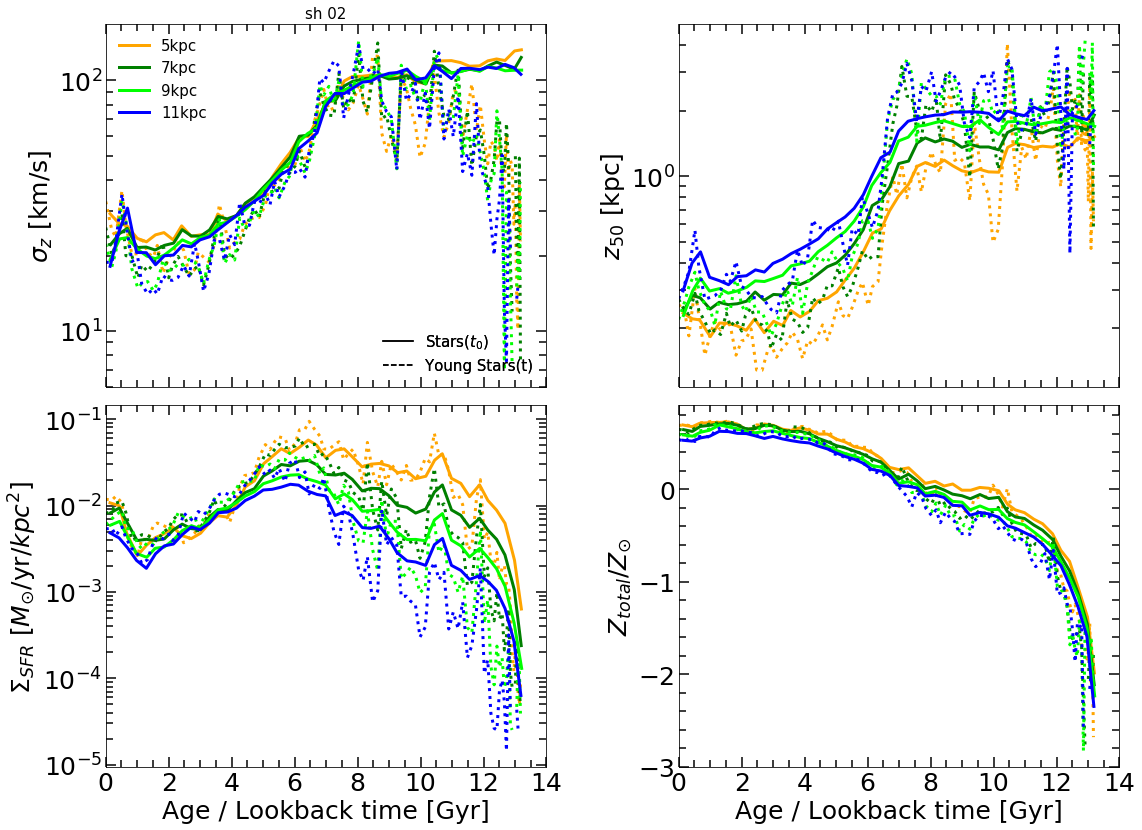

In [43]:
import numpy as np
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

r50 = np.loadtxt('../_data/r50.dat')[:,1]

colors = ('orange', 'green', 'lime', 'b','m')

for i in range(1): 
    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    radius = (5,7,9,11)#(r50[i]/4, r50[i]/2, r50[i], r50[i]+r50[i]/2, r50[i]*2)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    fig.subplots_adjust(bottom=0.10, left =0.10, right = 0.98,top=0.96, hspace=0.05, wspace=0.3)
    
    for k in range(len(radius)):
        data = np.loadtxt('../_data/Fig3.10/fig3.10_2_sh'+Id+'_r'+str('%s'%k)+'.dat')

        edad    = data[:,0]
        sigma_z = data[:,1]
        z_50    = data[:,2]        
        met     = data[:,3]        
        SFR     = data[:,4]
        SSFR    = data[:,5]
        
        data2 = np.loadtxt('../_data/Fig3.10/fig3.10_snap_sh'+Id+'_r'+str('%d'%radius[k])+'.dat')
    
        tiempo      = data2[:,0]
        sigma_z_str = data2[:,1]
        z_50_str    = data2[:,2]        
        met_str     = data2[:,3]        
        SFR_str     = data2[:,4]
        SSFR_str    = data2[:,5]
        
    
        ax[0,0].plot(edad,sigma_z,'-',lw=3, color = colors[k], label=str('%d'%radius[k])+'kpc')
        ax[0,0].plot(tiempo,sigma_z_str,':',lw=3, color = colors[k])
        ax[0,1].plot(edad,z_50,'-',lw=3, color= colors[k])
        ax[0,1].plot(tiempo,z_50_str,':',lw=3, color= colors[k])
        ax[1,0].plot(edad,SSFR,'-',lw=3, color= colors[k])
        ax[1,0].plot(tiempo,SSFR_str,':',lw=3, color= colors[k])
        ax[1,1].plot(edad,np.log10(met),'-',lw=3, color= colors[k])
        ax[1,1].plot(tiempo,np.log10(met_str),':',lw=3, color= colors[k])
    
    ax[0,0].plot((-2,-1),(40,50),'k-',label='Stars($t_0$)')
    ax[0,0].plot((-2,-1),(40,50),'k--',label='Young Stars(t)')
    ax[0,0].set_xlim(0,14)
    ax[0,0].set_xticks([0,2,4,6,8,10,12,14])
    ax[0,0].set_yscale('log')
    ax[0,0].set_xticklabels([])
    ax[0,0].minorticks_on()
    ax[0,0].tick_params(labelsize=25)
    ax[0,0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0,0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0,0].set_ylabel('$\sigma_z$ [km/s]',fontsize=25)
    ax[0,0].set_title('sh '+Id, fontsize=15)
    lines = ax[0,0].get_lines()
    legend1 = ax[0,0].legend([lines[i] for i in range(0,8,2)],[lines[i].get_label() for i in range(0,8,2)],
                             frameon=False, fontsize=15,loc=2)
    ax[0,0].add_artist(legend1)
    legend2 = ax[0,0].legend([lines[i] for i in range(8,10)],[lines[i].get_label() for i in range(8,10)],
                             frameon=False, fontsize=15,loc=4)
    ax[0,0].add_artist(legend2)
    
    
    ax[0,1].set_xlim(0,14)
    ax[0,1].set_xticks([0,2,4,6,8,10,12,14])
    ax[0,1].set_xticklabels([])
    ax[0,1].set_yscale('log')
    ax[0,1].minorticks_on()
    ax[0,1].tick_params(labelsize=25)
    ax[0,1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0,1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0,1].set_ylabel('$z_{50}$ [kpc]',fontsize=25)
    
    
    ax[1,0].set_xlim(0,14)
    ax[1,0].set_xticks([0,2,4,6,8,10,12,14])
    ax[1,0].set_yscale('log')
    ax[1,0].minorticks_on()
    ax[1,0].tick_params(labelsize=25)
    ax[1,0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1,0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1,0].set_ylabel('$\Sigma_{SFR}$ [$M_{\odot}$/yr/$kpc^2$]',fontsize=25)
    ax[1,0].set_xlabel('Age / Lookback time [Gyr]',fontsize=25)
    
    
    ax[1,1].set_xlim(0,14)
    ax[1,1].set_xticks([0,2,4,6,8,10,12,14])
    ax[1,1].minorticks_on()
    ax[1,1].tick_params(labelsize=25)
    ax[1,1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1,1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1,1].set_ylabel('$Z_{total}$/$Z_{\odot}$',fontsize=25)
    ax[1,1].set_xlabel('Age / Lookback time [Gyr]',fontsize=25)
    

    plt.show()
    
    fig.savefig('../_imagenes/Fig3.10/Fig3.10_2_sh'+Id+'.png',dpi=100, xxbox_inches='tight')    

/z/omarioni/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/z/omarioni/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


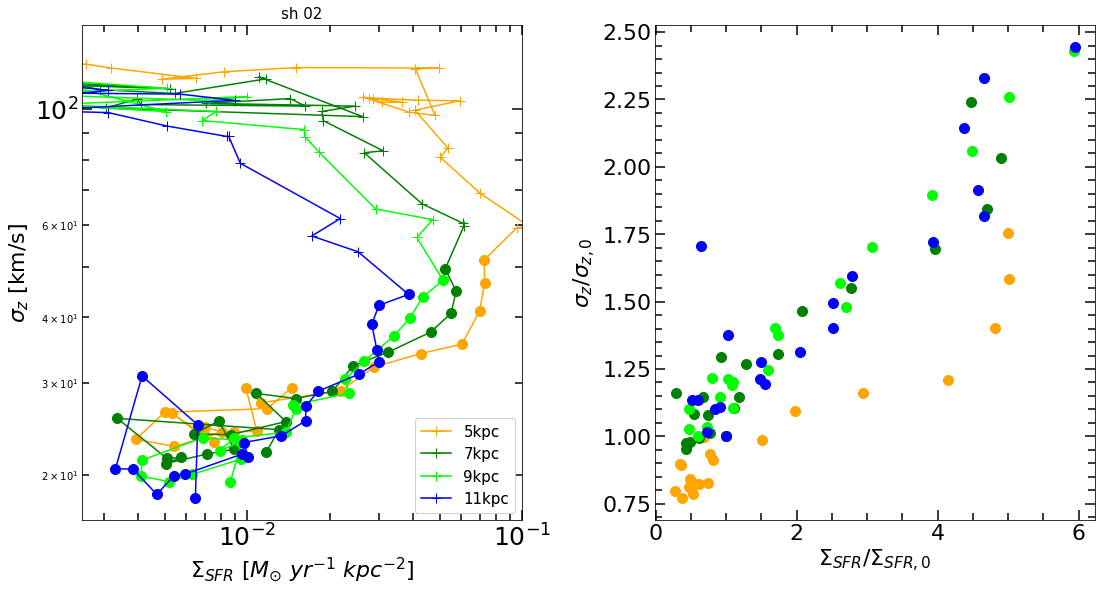

In [44]:
import numpy as np
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

r50 = np.loadtxt('../_data/r50.dat')[:,1]

colors = ('orange', 'green', 'lime', 'b','m')

for i in range(1): 
    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    radius = (5,7,9,11)#(r50[i]/4, r50[i]/2, r50[i], r50[i]+r50[i]/2, r50[i]*2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    fig.subplots_adjust(bottom=0.10, left =0.10, right = 0.98,top=0.96, hspace=0.05, wspace=0.3)
    
    for k in range(len(radius)):
        data = np.loadtxt('../_data/Fig3.10/fig3.10_2_sh'+Id+'_r'+str('%s'%k)+'.dat')

        edad    = data[:,0]
        sigma_z = data[:,1]
        z_50    = data[:,2]        
        met     = data[:,3]        
        SFR     = data[:,4]
        SSFR    = data[:,5]
        
        data2 = np.loadtxt('../_data/Fig3.10/fig3.10_snap_sh'+Id+'_r'+str('%d'%radius[k])+'.dat')
    
        tiempo      = data2[:,0]
        SSFR_gas    = data2[:,10]
        
        age_lim, = np.where((edad>=0) & (edad<=6))
        
        SSFR_GAS = np.ones(len(edad))*np.nan
        
        for j in range(len(edad)-1):
            mask, = np.where((tiempo >= edad[j]) & (tiempo < edad[j+1]))
            
            SSFR_GAS[j] = np.median(SSFR_gas[mask])
            
        
        ax[0].plot(SSFR_GAS[age_lim],sigma_z[age_lim], 'o',ms=10,color=colors[k])
        ax[0].plot(SSFR_GAS,sigma_z, '-+',ms=10, color=colors[k],label=str('%d'%radius[k])+'kpc')
        ax[1].plot(SSFR_GAS[age_lim]/SSFR_GAS[age_lim][0],sigma_z[age_lim]/sigma_z[age_lim][0], 'o',ms=10,color=colors[k])
        
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlim(2.5e-3,1e-1)
    ax[0].minorticks_on()
    ax[0].tick_params(labelsize=25)
    ax[0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0].set_xlabel('$\Sigma_{SFR}$ [$M_{\odot}$ $yr^{-1}$ $kpc^{-2}$]',fontsize=22)
    ax[0].set_ylabel('$\sigma_z$ [km/s]',fontsize=22)
    ax[0].set_title('sh '+Id, fontsize=15)
    lines = ax[0].get_lines()
    legend1 = ax[0].legend([lines[i] for i in range(1,8,2)],[lines[i].get_label() for i in range(1,8,2)],
                             fancybox=True, fontsize=15,loc=4)
    ax[0].add_artist(legend1)
        
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=22)
    ax[1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1].set_xlabel('$\Sigma_{SFR}$/$\Sigma_{SFR,0}$',fontsize=22)
    ax[1].set_ylabel('$\sigma_z$/$\sigma_{z,0}$',fontsize=22)
        
    plt.show()

In [41]:
len(edad)

19